In [1]:
# sys, file and nav packages:
import os
import datetime as dt
import csv

# math packages:
import pandas as pd
import math
import numpy as np
import datetime as dt 

from scipy import stats
from scipy.stats import kendalltau, pearsonr, spearmanr
# from scipy.stats import gamma
# from scipy.stats import beta
# from scipy.stats import binom
# from scipy.stats import bernoulli

# import statsmodels.api as sm
# from statsmodels.graphics.gofplots import qqplot_2samples
# from statsmodels.distributions.empirical_distribution import ECDF

# charting:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker
import matplotlib.ticker as mtick
import seaborn as sns
# from matplotlib.gridspec import GridSpec
# from matplotlib import cm
# from matplotlib.colors import ListedColormap, LinearSegmentedColormap, Colormap

# mapping
# import geopandas as gpd

# home brew utitilties
import utilities.utility_functions as ut
import utilities.abundance_classes as ac

# documenting
from IPython.display import display, Markdown, Latex, HTML


# returns the p_value for each test
def kendall_pval(x,y):
    return kendalltau(x,y)[1]

def pearsonr_pval(x,y):
    return pearsonr(x,y)[1]

def spearmanr_pval(x,y):
    return spearmanr(x,y)[1]

# table kwargs
table_k = dict(loc="top left", bbox=(0,0,1,1), colWidths=[.5, .5], cellLoc='center')
tablecenter_k = dict(loc="top left", bbox=(0,0,1,1), cellLoc='center')
tabtickp_k = dict(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelleft=False, labelbottom=False)

# chart kwargs
title_k = {'loc':'left', 'pad':14, 'linespacing':1.5, 'fontsize':12}
title_k14 = {'loc':'left', 'pad':16, 'linespacing':1.5, 'fontsize':14}
xlab_k = {'labelpad':10, 'fontsize':12}
ylab_k = {'labelpad':14, 'fontsize':14}


# # use these to format date axis in charts
# weeks = mdates.WeekdayLocator(byweekday=1, interval=4)
# # onedayweek = mdates.DayLocator(bymonthday=1, interval=1)
# # everytwoweeks = mdates.WeekdayLocator(byweekday=1, interval=4)

# months = mdates.MonthLocator(bymonth=[3,6,9,12])
# bimonthly = mdates.MonthLocator(bymonth=[1,3,5,7,9,11])
# allmonths = mdates.MonthLocator()
# wks_fmt = mdates.DateFormatter('%d')
# mths_fmt = mdates.DateFormatter('%b')

# map marker size:
survey_data, location_data, code_defs, stat_ent, geo_data, output = ut.make_local_paths()

### Discussion:

Based on the results of the 344 surveys from 122 locations in 70 riparian municipalities tobacco products are ~16% of the total number of objects found and they were identified at 81% of the survey locations. Food related objects are ~18% of the total and were found at 93% of the survey locations __\(figure 1\)__ . 86% of all objects identified were plastic, including expanded and extruded foams, sheet like plastics and fragmented plastics __\(figure 6\)__ .

#### geographic spread

While tobacco objects were identified frequently there are other objects that have a similar geoprahic spread:\*:

1. waste water 63% of all locations
2. polystyrene 67% of all locations
3. sheeting 69% of all locations

Tobacco products have been identified at all sample locations on Zurichsee, Laggo Maggiore and Thunersee, all of these features have more than ten surveys. On the other hand only 77% of locations on Bielersee and 88% on Walensee have had tobacco products identified (greater than ten surveys also) . Which means that while tobacco products are a significant problem in these areas there are other objects that maybe more diffuse in the local environment __\(figure 2\)__.

_\*pandemic articles have been found at 18% of locations_

#### abundance - regional differences

After tobacco objects, Polystrene pieces are ~13% of the total objects found, followed by plastic sheeting ~5%, and waste water ~5%. The most numerous objects are different for each water feature. For example on Lac Léman, Brienzersee and Lago Maggiore polystyrene and food products replace tobacco products as the the most numerous objects __\(figure 3, 4 and 5\)__.

#### influences

Early results suggest a correlation between the amount of insfrastructure (buildings, streets) around a survey area and the number of tobacco objects found. This agrees with the assumption that tobacco products are primarily found at the location in wich they were used.

#### just cigarette butts

Considered individually, cigarette butts are ~15% of all objects found  __\(figure 7\)__ . The top five objects found:

1. cigarette butts ~15%
2. polystyrene all sizes ~13%
3. fragmented plastics > 5mm ~14%
4. candy snack wrappers ~6%
5. plastic sheeting ~5%

### Conclusion

Considered either individually or in a group cigarette butts or tobacco products are responsible for %15 - 16% of all objects identified, which is a greater portion than anyother individual item. However the % total of tobacco products is not the same for all features, on Lac Léman tobacco products are 11% of the total and on Zurichsee 27%. 

Unlike plastic sheeting and polystyrene, cigarette butts can be linked to frequenlty observed behavior at most survey locations. Reinforcing the assumption that tobacco products are a result of littering at the survey location and objects like polystyrene and plastic sheeting are more diffuse in the body of water.

In [2]:
# set some parameters:
start_date = '2020-04-01'
end_date = '2021-04-01'

startyearmonth = '{}/{}'.format(start_date[5:7], start_date[:4])
endyearmonth = '{}/{}'.format(end_date[5:7], end_date[:4]) 

# decide which data to use
aggregated = False


# collect the names:
# group_names = list(these_groups.keys())

# choose a lake:
# lake = 'Lac Léman'
coi = 'Neuchâtel'
bassin_label = 'Aare'
bassin = ['Aare', 'Aare|Nidau-Büren-Kanal','Schüss', 'Neuenburgersee', 'Thunersee','Bielersee', 'Brienzersee','La Thièle']
bassin_lmn = ['Rhône', 'Lac Léman']
samples_all = 'All samples'



# define a significant event:
sig = .9
one_minus_sig = (1-sig)

# define explanatory variables:
expv = ['population','streets','buildings','rivs']

# name the folder:
name_of_project = 'reply'

# use this to store things:
project_directory = ut.make_project_folder(output, name_of_project)

# keep track of output
files_generated = []
figure_num = 0
data_num = 0

def add_output(**kwargs):
    files_generated.append({'tag':kwargs['tag'], 'number':kwargs['figure_num'], 'file':kwargs['file'],'type':kwargs['a_type']})
    if kwargs['a_type'] == 'data':
        kwargs['data'].to_csv(F"{kwargs['file']}.csv", index=False)
    else:
        plt.savefig(F"{kwargs['file']}.jpeg", dpi=300)

In [3]:
# non aggregated survey data
# Zero values are assigned for all codes not identified at a survey, for each survey
dfSurveys = pd.read_csv(F"{survey_data}/results_with_zeroes.csv")

# housekeeping set the date boundaries of the data
dfSurveys = dfSurveys[(dfSurveys.date >= start_date)&(dfSurveys.date <= end_date)]
dfSurveys['date'] = pd.to_datetime(dfSurveys['date'], format="%Y-%m-%d")

# allow for groups
dfSurveys['groupname'] = 'nogroup'

In [4]:
# beach data
dfBeaches = pd.read_csv(F"{location_data}/beaches_with_ranks.csv")
dfBeaches.set_index('slug', inplace=True)
dfBeaches.rename(columns={"NUMPOINTS":"intersects"}, inplace=True)

# code definitions
dfCodes = pd.read_csv(F"{code_defs}/mlw_codes.csv", index_col='code')

In [5]:
group_names_locations = {
    "waste water": "wastewater.json" ,
    "less than 5mm":"codeListMicros.json",
    "construction":"construction.json",
    "food":"foodstuff.json",
    "agg-con-trans":"cat.json",
    "agriculture":"ag.json",
    "tobacco":"tobac.json",
    "recreation":"recreation.json",    
    "packaging":"packaging.json",
    "personal items":"pi.json",    
}


frag_plas = {"fragmented plastics":["G79", "G78", "G75"]}
levels={'muni':coi, 'catchment':bassin_label}

these_cols = ['loc_date', 'location', 'water_name','type', 'date']
catchment_cols = ['region','water_name','type','city','loc_date', 'location', 'date']
foams={'G82':['G82', 'G912'], 'G81':['G81', 'G911'], 'G74':['G74', 'G910', 'G909']}

In [6]:
data = dfSurveys.copy()
data.set_index('location', inplace=True)

In [7]:
lakes = dfBeaches.water == 'l'
rivers = dfBeaches.water == 'r'
bssn = dfBeaches.water_name.isin(bassin)

data['type'] = 't'
data.loc[lakes, 'type'] = 'l'
data.loc[rivers, 'type'] = 'r'

In [8]:
data.reset_index(inplace=True)
a = ac.PreprocessData(data, dfBeaches,these_cols=these_cols, foams=foams, start_date=start_date, end_date=end_date)
bassin = a.processed.water_name.unique()
clas_kwargs = dict(
    code_group_data=group_names_locations,
    new_code_group=frag_plas,
    levels=levels,
    catchment_features=bassin,
    end_date=end_date,
    start_date=start_date,
    code_group_loc=output,
    catchment_cols=catchment_cols)


code maps done
agg foams complet
added exp vs


In [9]:
b = ac.CatchmentArea(a.processed, dfBeaches, **clas_kwargs)

made code groups
making group map
assigned results to code groups
assigned regional labels
assigned results to code groups
assigned regional labels
made code totals
made code totals


In [10]:
clas_kwargs.update({'catchment_features':bassin})
clas_kwargs.update({'muni':coi, 'catchment':bassin_label})
c = ac.CatchmentArea(a.processed, dfBeaches, **clas_kwargs)

made code groups
making group map
assigned results to code groups
assigned regional labels
assigned results to code groups
assigned regional labels
made code totals
made code totals


### Geographic spread and frequency

In [11]:
wfoams = ['G81', 'G82', 'G117']
yfoams = ['G74', 'G73', 'G75']
pand = ['G900', 'G901', 'G902']
# candy = ['G30']
# personal_hygiene = dfCodes.loc[dfCodes.source == 'Personal hygiene'].index.to_numpy()
# tobacco_codes = dfCodes.loc[dfCodes.source == 'Tobacco'].index.to_numpy()

# make a copy of the data to work with
som_data = b.bassin_data.copy()
data_num+=1
# 'tag':kwargs['tag'], 'number':kwargs['figure_num'], 'file':kwargs['file'],'type':kwargs['a_type']
a_tag = 'data used for all calculations'

file = F"{project_directory}/all_data_used.csv"
a_type='data'

add_output(tag=a_tag, figure_num=data_num, a_type=a_type, file=file, data=som_data)

In [12]:
number_of_samples = len(som_data.loc_date.unique())
number_of_locations = len(som_data.location.unique())
number_of_objects = som_data.quantity.sum()
number_of_cities = len(som_data.city.unique())
print(F"The number of samples, number of locations, the total number of objects and the number of cities:\n\n1. number of samples: {number_of_samples}\n2. number of locations: {number_of_locations}\n3. number of objects: {number_of_objects}\n4. number of cities: {number_of_cities}\n")
print(F"\nThe data is limited to all samples on or after {start_date} and up to {end_date}")

The number of samples, number of locations, the total number of objects and the number of cities:

1. number of samples: 344
2. number of locations: 122
3. number of objects: 49635
4. number of cities: 70


The data is limited to all samples on or after 2020-04-01 and up to 2021-04-01


In [13]:
print(F"There are {len(som_data.water_name.unique())} different water features:\n\n{som_data.water_name.unique()}")

There are 24 different water features:

['Lac Léman' 'Limmat' 'Sihl' 'Bielersee' 'Zurichsee' 'Lago Maggiore'
 'Ticino' 'Zugersee' 'Neuenburgersee' 'Aare' 'Rhône' 'Schüss' 'Walensee'
 'Thunersee' 'Brienzersee' 'Jona' 'Reuss' 'Linthkanal' 'Maggia'
 'La Thièle' 'Aare|Nidau-Büren-Kanal' 'Dorfbach' 'Escherkanal' 'Seez']


In [14]:
# the number of locations by feature
num_loc_feature = som_data.groupby('water_name', as_index=False).location.nunique()
print(F"The number of sample locations by feature:\n\n{num_loc_feature.set_index('water_name')}")

The number of sample locations by feature:

                        location
water_name                      
Aare                          12
Aare|Nidau-Büren-Kanal         2
Bielersee                      9
Brienzersee                    3
Dorfbach                       1
Escherkanal                    1
Jona                           1
La Thièle                      1
Lac Léman                     23
Lago Maggiore                  9
Limmat                         4
Linthkanal                     2
Maggia                         1
Neuenburgersee                10
Reuss                          2
Rhône                          8
Schüss                         1
Seez                           2
Sihl                           2
Thunersee                      7
Ticino                         1
Walensee                       9
Zugersee                       1
Zurichsee                     10


In [15]:
# mark all records where the quantity > 0 as True
som_data['fail'] = som_data.quantity > 0

# number of locations where pandemic related articles were found:
found_pandemic = som_data[som_data.code.isin(pand)].groupby(['water_name', 'location'], as_index=False).quantity.sum()
found_pandemic['found'] = found_pandemic.quantity > 0
found_pandemic_feature = found_pandemic.groupby('water_name').found.sum()

# number of locations where tobacco related articles were found:
found_tobacco = som_data[som_data.groupname == "tobacco"].groupby(['water_name', 'location'], as_index=False).quantity.sum()
found_tobacco['found'] = found_tobacco.quantity > 0
found_tobacco_feature = found_tobacco.groupby('water_name').found.sum()

# number of locations where expanded polystyrene was found:
found_eps = som_data[som_data.code.isin(wfoams)].groupby(['water_name', 'location'], as_index=False).quantity.sum()
found_eps['found'] = found_eps.quantity > 0
found_eps_feature = found_eps.groupby('water_name').found.sum()

# number of locations where 'agg-con-trans' related articles were found:
found_act = som_data[som_data.code == "G67"].groupby(['water_name', 'location'], as_index=False).quantity.sum()
found_act['found'] = found_act.quantity > 0
found_act_feature = found_act.groupby('water_name').found.sum()

# number of locations where food related articles were found:
found_food = som_data[som_data.groupname == "food"].groupby(['water_name', 'location'], as_index=False).quantity.sum()
found_food['found'] = found_food.quantity > 0
found_food_feature = found_food.groupby('water_name').found.sum()

# number of locations where waste water related articles were found:
found_wt = som_data[som_data.groupname == 'waste water'].groupby(['water_name', 'location'], as_index=False).quantity.sum()
found_wt['found'] = found_wt.quantity > 0
found_wt_feature = found_wt.groupby('water_name').found.sum()

group_maps = {
    'pandemic':found_pandemic_feature,
    "tobacco":found_tobacco_feature,
    'polystyrene':found_eps_feature,
    "plastic sheeting":found_act_feature,
    "food":found_food_feature,
    "waste water":found_wt_feature,   
}

In [16]:
for a_group in group_maps:
    num_loc_feature[a_group] = num_loc_feature.water_name.map(lambda x: group_maps[a_group].loc[x])
num_loc_feature.set_index('water_name', inplace=True)

In [17]:
data_num += 1
a_tag = 'number of locations where object was found'

file = F"{project_directory}/number_locations_found.csv"
a_type='data'

add_output(tag=a_tag, figure_num=data_num, a_type=a_type, file=file, data=num_loc_feature)

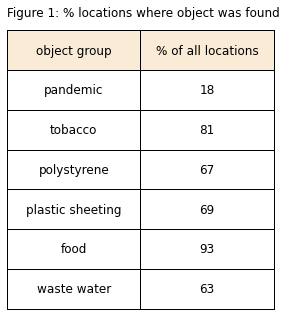

In [18]:
num_loc_feature_p_total = num_loc_feature.sum()/122 * 100
num_loc_feature_p_total = num_loc_feature_p_total.astype('int')
table_data = pd.DataFrame(num_loc_feature_p_total).reset_index()
table_data.rename(columns={'index':'object group', 0: '% of all locations'}, inplace=True)
table_data = table_data.loc[table_data['object group'] != 'location']

figure_num += 1
output_kwargs = dict(file = F"{project_directory}/figure{figure_num}", files_generated=files_generated, a_type="table", tag=F"% of locations with at least one", figure_num=figure_num)
# add_output(**output_kwargs)
# files_generated.append({'tag':kwargs['tag'], 'number':kwargs['figure_num'], 'file':kwargs['file'],'type':kwargs['a_type']})
# adjust the table kwargs (# of columns):
tablecenter_k = dict(loc="center", bbox=(0,0,1,1), colWidths=[50,50], cellLoc='center')
title=F"Figure {figure_num}: % locations where object was found"

files_generated = ac.makeMultiColumnTable(table_data, title=title, output=True, o_kwargs=output_kwargs, t_kwargs=tablecenter_k, tick_params=tabtickp_k, title_kwargs=title_k)

In [19]:
per_total_feature = pd.DataFrame(index=num_loc_feature.index, columns=[num_loc_feature.columns[1:]])
for feature in per_total_feature.index:
    for col in num_loc_feature.columns[1:]:
        per_total_feature.loc[feature][col] = num_loc_feature.loc[feature][col]/num_loc_feature.loc[feature].location
        
per_total_feature.columns = per_total_feature.columns.get_level_values(0)

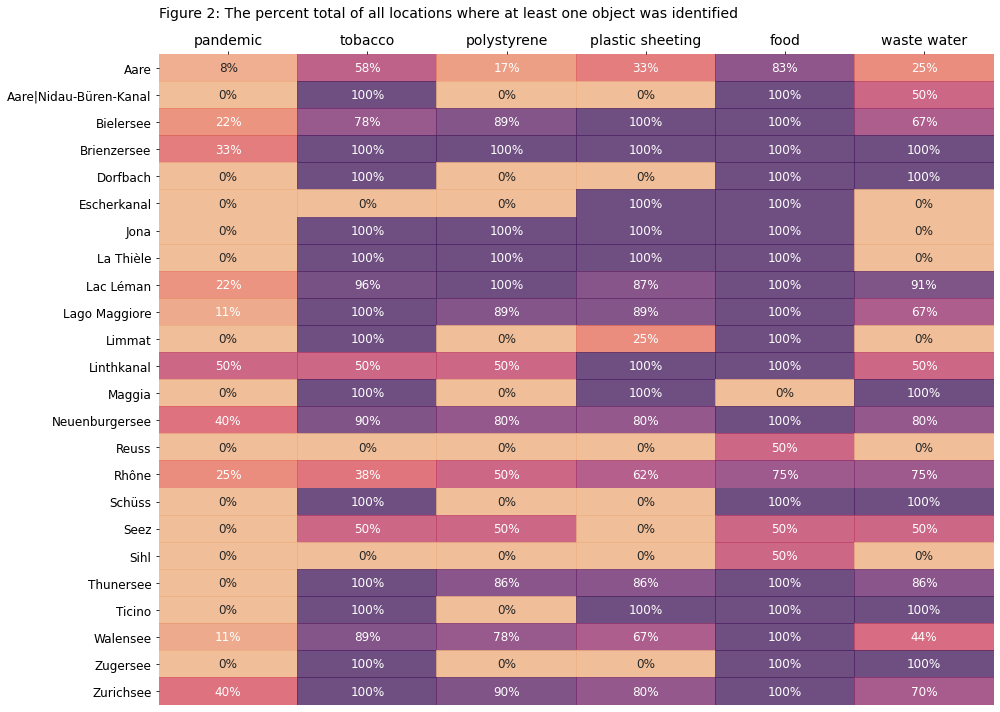

In [20]:
fig, ax = plt.subplots(figsize=(14,10))
table_data = per_total_feature.fillna(0)
figure_num += 1
title = F"Figure {figure_num}: The percent total of all locations where at least one object was identified"

sns.heatmap(data=table_data, cmap='flare', fmt=".0%", annot=True, ax=ax, annot_kws={"fontsize":12},alpha=0.8, cbar=False)
ax.set_ylabel("")
ax.set_xlabel("")
ax.xaxis.set_ticks_position('top')
ax.tick_params(axis='x', which='both',labelsize=14)
yticklabs = ax.get_yticklabels()
ax.set_yticklabels(yticklabs, fontsize=12, rotation=0)
ax.set_title(title, **title_k14)

plt.tight_layout()

o_kwargs = dict(file = F"{project_directory}/figure{figure_num}", a_type="figure", tag=F"% of locations where objects found", figure_num=figure_num)

add_output(**o_kwargs)

plt.show()

plt.close()

### Abundance: number of objects and percent of total

In [21]:
# number of locations where pandemic related articles were found:

feature_total = pd.DataFrame(index=num_loc_feature.index, columns=[num_loc_feature.columns[1:]])
tobacco_total = found_tobacco.groupby('water_name').quantity.sum()
food_total = found_food.groupby('water_name').quantity.sum()
pandemic_total = found_pandemic.groupby('water_name').quantity.sum()
eps_total = found_eps.groupby('water_name').quantity.sum()
act_total = found_act.groupby('water_name').quantity.sum()
wt_total = found_wt.groupby('water_name').quantity.sum()
feature_total.columns = feature_total.columns.get_level_values(0)

group_maps = {
    'pandemic':pandemic_total,
    "tobacco":tobacco_total,
    'polystyrene':eps_total,
    "plastic sheeting":act_total,
    "food":food_total,
    "waste water":wt_total,    
}

In [22]:
for a_group in group_maps:
    feature_total[a_group] = feature_total.index.map(lambda x: group_maps[a_group].loc[x])

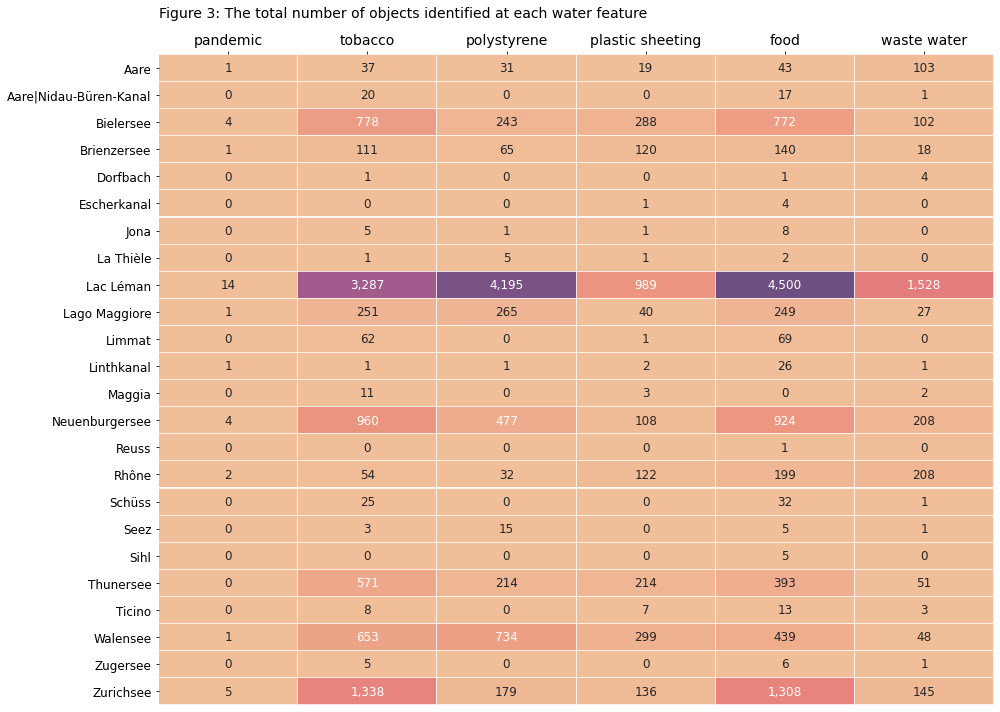

In [23]:
table_data = feature_total
table_data = table_data.fillna(0)
# table_data.round(1)
figure_num += 1
fig, ax = plt.subplots(figsize=(14,10))
title = F"Figure {figure_num}: The total number of objects identified at each water feature"

sns.heatmap(data=table_data, cmap='flare', linewidth=0.1, linecolor='white', fmt=",", annot=True, ax=ax, annot_kws={"fontsize":12},alpha=0.8, cbar=False)
ax.set_ylabel("")
ax.set_xlabel("")
ax.xaxis.set_ticks_position('top')
ax.tick_params(axis='x', which='both',labelsize=14)
yticklabs = ax.get_yticklabels()
ax.set_yticklabels(yticklabs, fontsize=12, rotation=0)
ax.set_title(title, **title_k14)

plt.tight_layout()

o_kwargs = dict(file = F"{project_directory}/figure{figure_num}", a_type="figure", tag=F"total number of objects found", figure_num=figure_num)

add_output(**o_kwargs)

plt.show()

plt.close()

In [24]:
q_total_feature = pd.DataFrame(index=num_loc_feature.index, columns=[num_loc_feature.columns[1:]])
feature_totals_all = som_data.groupby('water_name').quantity.sum()

In [25]:
for feature in feature_total.index:
    for col in num_loc_feature.columns[1:]:
        q_total_feature.loc[feature][col] = feature_total.loc[feature][col]/feature_totals_all.loc[feature]

q_total_feature.columns = q_total_feature.columns.get_level_values(0)

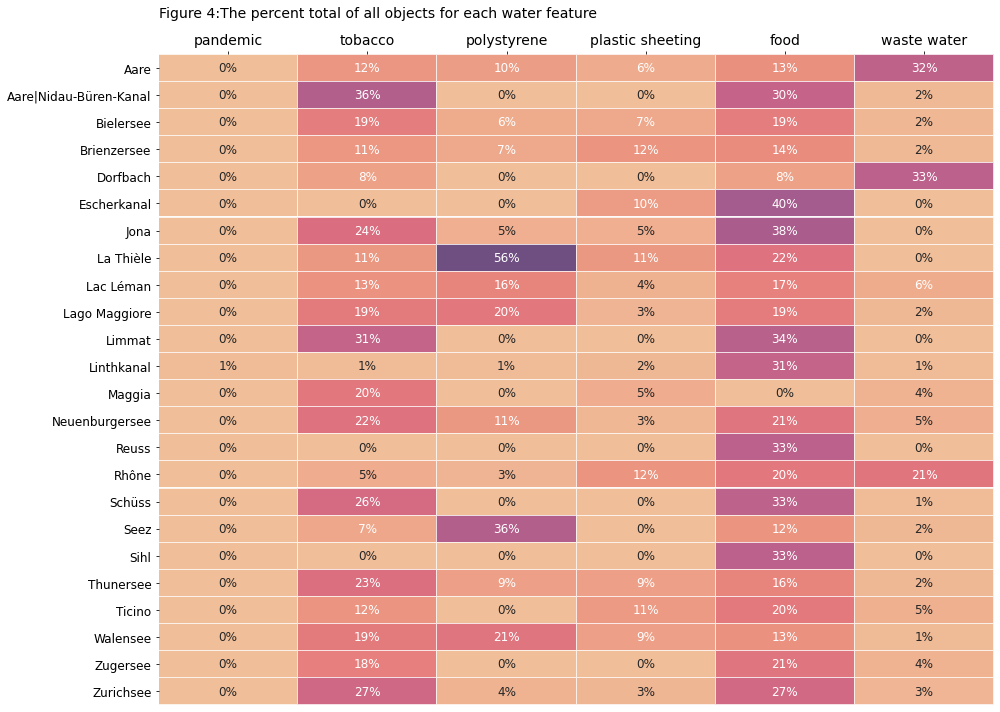

In [26]:
table_data = q_total_feature
table_data = table_data.fillna(0)
figure_num += 1

fig, ax = plt.subplots(figsize=(14,10))
title = F"Figure {figure_num}:The percent total of all objects for each water feature"

sns.heatmap(data=table_data, cmap='flare', linewidth=0.1, linecolor='white', fmt=".0%", annot=True, ax=ax, annot_kws={"fontsize":12},alpha=0.8, cbar=False)
ax.set_ylabel("")
ax.set_xlabel("")
ax.xaxis.set_ticks_position('top')
ax.tick_params(axis='x', which='both',labelsize=14)
yticklabs = ax.get_yticklabels()
ax.set_yticklabels(yticklabs, fontsize=12, rotation=0)
ax.set_title(title, **title_k14)

plt.tight_layout()

o_kwargs = dict(file = F"{project_directory}/figure{figure_num}", a_type="figure", tag=F"% of total objects found", figure_num=figure_num)

add_output(**o_kwargs)

plt.show()

plt.close()

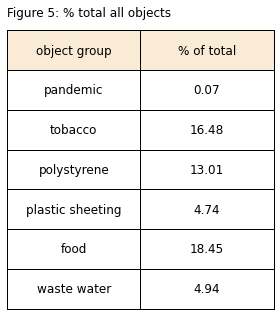

In [27]:
# print(feature_total.sum())
feature_total_qptotal = (feature_total.sum()/som_data.quantity.sum())*100
table_data = pd.DataFrame(feature_total_qptotal).reset_index()
table_data.rename(columns={'index':'object group', 0: '% of total'}, inplace=True)
table_data = table_data.loc[table_data['object group'] != 'location']
table_data['% of total'] = table_data['% of total'].round(2)
data_num += 1
a_tag = 'number of objects per water feature'

file = F"{project_directory}/number_objects_found.csv"
a_type='data'
add_output(tag=a_tag, figure_num=data_num, a_type=a_type, file=file, data=feature_total)
# print(F"The total number of objects found by group all water features included:\n\n{feature_total.sum()}")
# print(F"\nThe percent of the total number of objects found all water features included:\n\n{feature_total_qptotal.round(2)}\n")

figure_num += 1
output_kwargs = dict(file = F"{project_directory}/figure{figure_num}", files_generated=files_generated, a_type="table", tag=F"total objects found by gorup", figure_num=figure_num)
# add_output(**output_kwargs)
# files_generated.append({'tag':kwargs['tag'], 'number':kwargs['figure_num'], 'file':kwargs['file'],'type':kwargs['a_type']})
# adjust the table kwargs (# of columns):
tablecenter_k = dict(loc="center", bbox=(0,0,1,1), colWidths=[50,50], cellLoc='center')
title=F"Figure {figure_num}: % total all objects"

files_generated=ac.makeMultiColumnTable(table_data, title=title, output=True, o_kwargs=output_kwargs, t_kwargs=tablecenter_k, tick_params=tabtickp_k, title_kwargs=title_k)

In [28]:
g27 = som_data[som_data.code == 'G27'].quantity.sum()
foams = som_data[som_data.code.isin(wfoams)].quantity.sum()
frag_plas = ["G79", "G78", "G80","G75","G76"]
f_plas = som_data[som_data.code.isin(frag_plas)].quantity.sum()
code_totals = b.bassin_code_totals.copy()
mt = b.bassin_code_totals.copy()

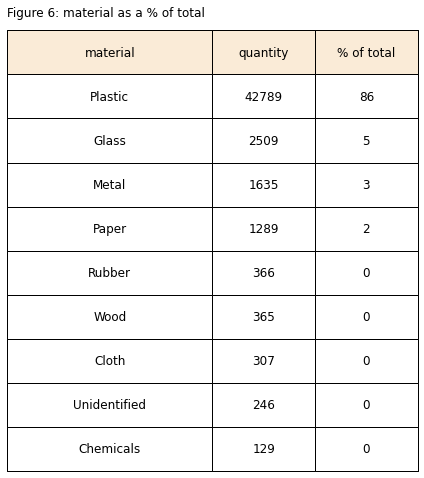

In [29]:
mt['material'] = mt.code.map(lambda x: dfCodes[dfCodes.index == x ].material.values[0])
mt = mt.groupby('material', as_index=False).quantity.sum()
mt['% of total'] = mt.quantity/mt.quantity.sum()
mt['% of total'] = mt['% of total']*100
mt['% of total'] = mt['% of total'].round(2)
figure_num += 1
output_kwargs = dict(file = F"{project_directory}/figure{figure_num}", files_generated=files_generated, a_type="table", tag=F"% total of materials", figure_num=figure_num)

# add_output(**o_kwargs)
table_data = mt.sort_values(by='quantity', ascending=False).copy()
# table_data.set_index('material', inplace=True, drop=True)
# table_data['% of total'] = table_data['% of total']*100
table_data['% of total'] = table_data['% of total'].astype('int')
# adjust the table kwargs (# of columns):
tablecenter_k = dict(loc="center", bbox=(0,0,1,1), colWidths=[50,25, 25], cellLoc='center')
title=F"Figure {figure_num}: material as a % of total"

files_generated = ac.makeMultiColumnTable(table_data, title=title, output=True, o_kwargs=output_kwargs, t_kwargs=tablecenter_k, tick_params=tabtickp_k, title_kwargs=title_k)

In [30]:

code_totals = code_totals[~code_totals.code.isin([*wfoams, *frag_plas])]

code_totals.loc[len(code_totals)] = ['GFoam',foams, foams/som_data.quantity.sum()]
code_totals.loc[len(code_totals)+1] = ['Gfragplas',f_plas, f_plas/som_data.quantity.sum()]

code_totals.set_index('code', inplace=True)
data_num+=1

o_kwargs = dict(file = F"{project_directory}/code_totals", a_type="data", tag=F"topen", figure_num=data_num, data=code_totals)
add_output(**o_kwargs)

In [31]:
end_table = code_totals.sort_values(by='quantity', ascending=False)[:10]
end_table.reset_index(inplace=True)
new_names = {
    "G27":"cigarette ends",
    "Gfragplas":"fragmented plastics",
    "GFoam":"expanded polystyrene",
    "G30":"snack wrappers",
    "G67":"plastic sheeting",
    "G200":"glass bottles pieces",
    "G112":"industrial pellets",
    "G74":"extruded polystyrene",
    "G95":"cotton swabs",
    "G89":"plastic construction material"    
}

end_table['description'] = end_table.code.map(lambda x: new_names[x])

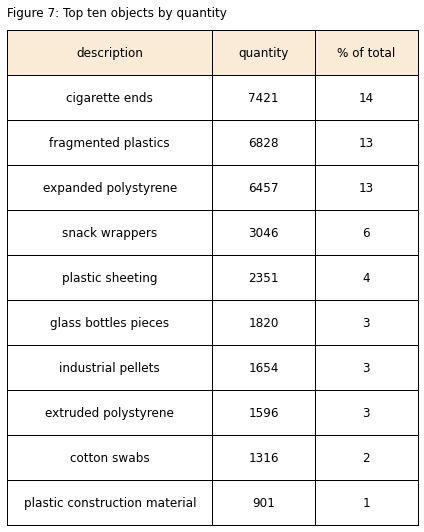

In [32]:
# figure_num += 1
# o_kwargs = dict(file = F"{project_directory}/figure{figure_num}",files_generated=files_generated, a_type="table", tag=F"topen", figure_num=figure_num)
figure_num += 1
output_kwargs = dict(file = F"{project_directory}/figure{figure_num}", files_generated=files_generated, a_type="table", tag=F"% of locations with at least one", figure_num=figure_num)

# add_output(**o_kwargs)
table_data = end_table[['description', 'quantity', '% of total']].copy()
table_data['% of total'] = table_data['% of total']*100
table_data['% of total'] = table_data['% of total'].astype('int')
# adjust the table kwargs (# of columns):
tablecenter_k = dict(loc="center", bbox=(0,0,1,1), colWidths=[50,25, 25], cellLoc='center')
title=F"Figure {figure_num}: Top ten objects by quantity"

files_generated = ac.makeMultiColumnTable(table_data, title=title, output=True, o_kwargs=output_kwargs, t_kwargs=tablecenter_k, tick_params=tabtickp_k, title_kwargs=title_k)

In [33]:
print("The files generated by this workbook:\n")
files_generated

The files generated by this workbook:



[{'tag': 'data used for all calculations',
  'number': 1,
  'file': 'output/reply/all_data_used.csv',
  'type': 'data'},
 {'tag': 'number of locations where object was found',
  'number': 2,
  'file': 'output/reply/number_locations_found.csv',
  'type': 'data'},
 {'tag': '% of locations with at least one',
  'number': 1,
  'file': 'output/reply/figure1',
  'type': 'table'},
 {'tag': '% of locations where objects found',
  'number': 2,
  'file': 'output/reply/figure2',
  'type': 'figure'},
 {'tag': 'total number of objects found',
  'number': 3,
  'file': 'output/reply/figure3',
  'type': 'figure'},
 {'tag': '% of total objects found',
  'number': 4,
  'file': 'output/reply/figure4',
  'type': 'figure'},
 {'tag': 'number of objects per water feature',
  'number': 3,
  'file': 'output/reply/number_objects_found.csv',
  'type': 'data'},
 {'tag': 'total objects found by gorup',
  'number': 5,
  'file': 'output/reply/figure5',
  'type': 'table'},
 {'tag': '% total of materials',
  'number':

#### Hopefully that just worked for you

if not contact analyst@hammerdirt.ch